In [35]:
import os
import gc
import time
import codecs
from datetime import date, datetime

random_seed = 42

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rc('lines', linewidth=4, color='g')

import warnings
warnings.filterwarnings('ignore')

In [36]:
import keras
import tensorflow as tf
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import (Dense, Activation, Dropout, Flatten, Bidirectional,
                          CuDNNGRU, Embedding, Conv1D, CuDNNLSTM,                           
                          MaxPooling1D, GlobalMaxPooling1D, LSTM) 
from keras.utils import plot_model, np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [59]:
from git import Repo

PATH_OF_GIT_REPO = r'/home/hq/Kaggle/.git'

def git_push(COMMIT_MESSAGE):
    try:
        repo = Repo(PATH_OF_GIT_REPO)
        repo.git.add(update=True)
        repo.index.commit(COMMIT_MESSAGE)
        origin = repo.remote(name='Kagglez')
        origin.push(refspec='master:master')
    except:
        print('Some error occured while pushing the code')

In [13]:
for dirname, _, filenames in os.walk('../Input/nfl-2020'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../Input/nfl-2020/train.csv
../Input/nfl-2020/kaggle/competitions/nflrush/sample_submission.csv.encrypted
../Input/nfl-2020/kaggle/competitions/nflrush/competition.cpython-36m-x86_64-linux-gnu.so
../Input/nfl-2020/kaggle/competitions/nflrush/__init__.py
../Input/nfl-2020/kaggle/competitions/nflrush/test.csv.encrypted


In [52]:
df = pd.read_csv('../Input/nfl-2020/train.csv')

In [53]:
df.shape, df.columns

((509762, 49),
 Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
        'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
        'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
        'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
        'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
        'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
        'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
        'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
        'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
        'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
       dtype='object'))

In [54]:
df.head(5)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [55]:
df.tail(5)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509760,2018123015,20181230154157,home,84.57,24.37,4.36,1.79,0.47,148.08,183.34,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509761,2018123015,20181230154157,home,80.80,26.35,4.87,4.10,0.45,135.44,118.24,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE


In [56]:
outcomes = df[['GameId','PlayId','Yards']].drop_duplicates()

In [62]:
def create_features(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate
    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    def static_features(df):
        static_features = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                            'YardLine','Quarter','Down','Distance','DefendersInTheBox']].drop_duplicates()
        static_features['DefendersInTheBox'] = static_features['DefendersInTheBox'].fillna(np.mean(static_features['DefendersInTheBox']))

        return static_features
    
    def split_personnel(s):
        splits = s.split(',')
        for i in range(len(splits)):
            splits[i] = splits[i].strip()

        return splits

    def defense_formation(l):
        dl = 0
        lb = 0
        db = 0
        other = 0

        for position in l:
            sub_string = position.split(' ')
            if sub_string[1] == 'DL':
                dl += int(sub_string[0])
            elif sub_string[1] in ['LB','OL']:
                lb += int(sub_string[0])
            else:
                db += int(sub_string[0])

        counts = (dl,lb,db,other)

        return counts

    def offense_formation(l):
        qb = 0
        rb = 0
        wr = 0
        te = 0
        ol = 0

        sub_total = 0
        qb_listed = False
        for position in l:
            sub_string = position.split(' ')
            pos = sub_string[1]
            cnt = int(sub_string[0])

            if pos == 'QB':
                qb += cnt
                sub_total += cnt
                qb_listed = True
            # Assuming LB is a line backer lined up as full back
            elif pos in ['RB','LB']:
                rb += cnt
                sub_total += cnt
            # Assuming DB is a defensive back and lined up as WR
            elif pos in ['WR','DB']:
                wr += cnt
                sub_total += cnt
            elif pos == 'TE':
                te += cnt
                sub_total += cnt
            # Assuming DL is a defensive lineman lined up as an additional line man
            else:
                ol += cnt
                sub_total += cnt

        # If not all 11 players were noted at given positions we need to make some assumptions
        # I will assume if a QB is not listed then there was 1 QB on the play
        # If a QB is listed then I'm going to assume the rest of the positions are at OL
        # This might be flawed but it looks like RB, TE and WR are always listed in the personnel
        if sub_total < 11:
            diff = 11 - sub_total
            if not qb_listed:
                qb += 1
                diff -= 1
            ol += diff

        counts = (qb,rb,wr,te,ol)

        return counts
    
    def personnel_features(df):
        personnel = df[['GameId','PlayId','OffensePersonnel','DefensePersonnel']].drop_duplicates()
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: defense_formation(x))
        personnel['num_DL'] = personnel['DefensePersonnel'].apply(lambda x: x[0])
        personnel['num_LB'] = personnel['DefensePersonnel'].apply(lambda x: x[1])
        personnel['num_DB'] = personnel['DefensePersonnel'].apply(lambda x: x[2])

        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: offense_formation(x))
        personnel['num_QB'] = personnel['OffensePersonnel'].apply(lambda x: x[0])
        personnel['num_RB'] = personnel['OffensePersonnel'].apply(lambda x: x[1])
        personnel['num_WR'] = personnel['OffensePersonnel'].apply(lambda x: x[2])
        personnel['num_TE'] = personnel['OffensePersonnel'].apply(lambda x: x[3])
        personnel['num_OL'] = personnel['OffensePersonnel'].apply(lambda x: x[4])

        # Let's create some features to specify if the OL is covered
        personnel['OL_diff'] = personnel['num_OL'] - personnel['num_DL']
        personnel['OL_TE_diff'] = (personnel['num_OL'] + personnel['num_TE']) - personnel['num_DL']
        # Let's create a feature to specify if the defense is preventing the run
        # Let's just assume 7 or more DL and LB is run prevention
        personnel['run_def'] = (personnel['num_DL'] + personnel['num_LB'] > 6).astype(int)

        personnel.drop(['OffensePersonnel','DefensePersonnel'], axis=1, inplace=True)
        
        return personnel

    def combine_features(relative_to_back, defense, static, personnel, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,personnel,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    personnel = personnel_features(df)
    basetable = combine_features(rel_back, def_feats, static_feats, personnel, deploy=deploy)
    
    return basetable

In [63]:
%%time 
df_basetable = create_features(df, False)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [65]:
df_basetable.head(5)

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,...,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,OL_diff,OL_TE_diff,run_def,Yards
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,...,6,1,1,3,1,5,3,4,0,8
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,...,6,1,1,3,1,5,3,4,0,3
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,...,6,1,1,3,1,5,3,4,0,5
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,...,3,1,2,0,2,6,2,4,1,2
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,...,6,1,1,1,3,5,2,5,0,7


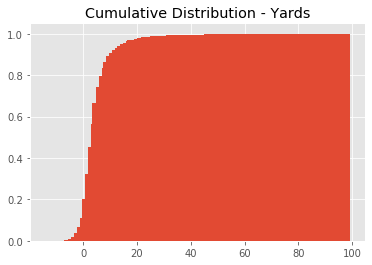

In [67]:
df["Yards"].hist(density = True, cumulative = True, bins = 200)
plt.title('Cumulative Distribution - Yards');

In [ ]:
git_push('insa')